Import Libraries

In [1]:
!pip install deap

import array
import random
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.cm as cm

from deap import base, creator, tools
from deap.benchmarks.tools import hypervolume
from sympy.combinatorics.graycode import random_bitstring, gray_to_bin, bin_to_gray

     |████████████████████████████████| 160 kB 14.1 MB/s 


Constants

In [2]:
# Binary length
BITS = 10
# -4.0 <= x1,x2,x3 <= 4.0
LOWER_BOUND, UPPER_BOUND = - 4, 4
# Number of genes (decision variables)
DECISION_VARIABLES = 3

POPULATION_SIZE = 25
NUMBER_OF_GENERATIONS = 30
OFFSPRING_SIZE = 25
CROSS_PROBABILITY = 0.9
MUTATION_PROBABILITY = 1/(BITS * DECISION_VARIABLES)

random.seed(10)

Functions

In [3]:
def gray_to_real(gray, lower, upper):
  """ Converts between gray coding to a 
  real value in range [lower, upper] """
  l = len(gray)
  # Converts to binary, then integer
  binary = gray_to_bin(gray)
  integer = int(binary, 2)
  # Converts to real-valued
  x = lower + (upper - lower) * (1 / (2**l  - 1)) * integer
  return x

In [4]:
def evaluation(individual):
  """ Evaluation function """
  # An individual's genes
  g1, g2, g3 = individual[0], individual[1], individual[2]
  # Converts from gray code to real-valued
  x1, x2, x3 = gray_to_real(g1, LOWER_BOUND, UPPER_BOUND), gray_to_real(g2, LOWER_BOUND, UPPER_BOUND), gray_to_real(g3, LOWER_BOUND, UPPER_BOUND)
  
  f1 = ((x1/2)**2 + (x2/4)**2 + x3**2) / 3
  f2 = (((x1/2) - 1)**2 + ((x2/4) - 1)**2 + (x3 - 1)**2) / 3
  return f1, f2

In [5]:
def check_dominated(individual, current_front):
  # Compare with individuals in current front starting from last
  for compare_ind in current_front[::-1]:
    if compare_ind.fitness.dominates(individual.fitness):
      return True
  return False

In [6]:
def sequential_search(ind, fronts):
  # Current front to check
  front_index = 0
  while True:
    current_front = fronts[front_index]
    dominated = check_dominated(ind, current_front)
    if not dominated:
      # Adds individual to current front
      fronts[front_index].append(ind)
      return fronts
    front_index += 1
    if front_index + 1 > len(fronts):
      # Add individual to new front
      new_front = [ind]
      fronts.append(new_front)
      return fronts

In [7]:
def efficient_ND_sort(population):
  """ Efficient non-dominated sorting """
  # Copies population to prevent population changing
  copy_population = toolbox.clone(population)
  # Sort population by f1, then by f2 is f1 is equal
  copy_population.sort(key=lambda ind: (ind.fitness.values[0], ind.fitness.values[1]))
  # Assigns best f1 to front 1
  fronts = [[copy_population[0]]]
  copy_population.remove(copy_population[0])
  for ind in copy_population:
    fronts = sequential_search(ind, fronts)
  return fronts

In [8]:
def assignCrowdingDist(front):
  """ Deap function to assign crowding distance to individuals in a front """
  if len(front) == 0:
    return
  distances = [0.0] * len(front)
  crowd = [(ind.fitness.values, i) for i, ind in enumerate(front)]

  nobj = len(front[0].fitness.values)

  for i in range(nobj):
      crowd.sort(key=lambda element: element[0][i])
      distances[crowd[0][1]] = float("inf")
      distances[crowd[-1][1]] = float("inf")
      if crowd[-1][0][i] == crowd[0][0][i]:
          continue
      norm = nobj * float(crowd[-1][0][i] - crowd[0][0][i])
      for prev, cur, next in zip(crowd[:-2], crowd[1:-1], crowd[2:]):
          distances[cur[1]] += (next[0][i] - prev[0][i]) / norm

  for i, dist in enumerate(distances):
      front[i].fitness.crowding_dist = dist

In [9]:
def compete(first, second):
  # Comparision based on dominance
  if first.fitness.dominates(second.fitness):
    return first
  elif second.fitness.dominates(first.fitness):
    return second
  # Comparision based on crowding distance
  if first.fitness.crowding_dist > second.fitness.crowding_dist:
    return first
  elif first.fitness.crowding_dist < second.fitness.crowding_dist:
    return second
  # Random selection
  if random.random() <= 0.5:
    return first
  return second

In [10]:
def binaryTournament(population, pair_number):
  """ Binary tournament selection
  Prevents the same individuals being repeatedly selected """
  # Pairs of selected individuals
  selected = []
  # Copies population
  copy_pop = [ind for ind in population]

  # Number of parent pairs
  for i in range(pair_number):
    # Randomly select two individuals
    first = random.choice(copy_pop)
    # Remove from population to prevent repeat selection
    copy_pop.remove(first)
    # Checks if all individuals selected
    if (len(copy_pop) == 0):
      # Adds more individuals for selection
      copy_pop = [ind for ind in population]
    second = random.choice(copy_pop)
    copy_pop.remove(second)
    if (len(copy_pop) == 0):
      copy_pop = [ind for ind in population]
    first_parent = compete(first, second)

    # Randomly select two more individuals
    first = random.choice(copy_pop)
    copy_pop.remove(first)
    if (len(copy_pop) == 0):
      copy_pop = [ind for ind in population]
    second = random.choice(copy_pop)
    if (len(copy_pop) == 0):
      copy_pop = [ind for ind in population]
    copy_pop.remove(second)
    second_parent = compete(first, second)
    selected.append([first_parent, second_parent])
    
  return selected

In [11]:
def flipMutation(individual, probability=0.1):
  # Iterates through decision variables
  for i in range(len(individual)):
    # Creates updated decision variable
    new_var = ""
    # Iterates through bits in decision variable
    for bit in individual[i]:
      new_bit = bit
      # Flip bit
      if random.random() <= probability:
        if bit == '0':
          new_bit = '1'
        if bit == '1':
          new_bit = '0'
      new_var += new_bit
    # Updates mutated decision variable
    individual[i] = new_var
  return individual

Genetic Algorithm

In [12]:
# Creates a fitness for minimization of a problem with 2 objectives
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# Creates class Individual with fitness set for minimization
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Generation function for decision variables using 10 bit gray coding
toolbox.register("gray_code", random_bitstring, BITS)
# Initializers for individual and population
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.gray_code, DECISION_VARIABLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Genetic operators
toolbox.register("evaluate", evaluation) # Uses evaluation function
toolbox.register("sort", efficient_ND_sort) # Non-dominated sorting into fronts
toolbox.register("crowd", assignCrowdingDist) # Assign crowding distance to each individual of the list
toolbox.register("tournament", binaryTournament) # Tournament selection
toolbox.register("mate", tools.cxUniform, indpb=0.5) # Uniform crossover with 50% chance of exchange
toolbox.register("mutate", flipMutation, probability=MUTATION_PROBABILITY) # Flip mutation with chance = 1 / chromosome length

In [13]:
def main():
  stats = tools.Statistics()
  logbook = tools.Logbook()
  logbook.header = "generation", "x1", "x2", "x3", "f1", "f2", "front_number", "crowding_distance"

  # Initiate the population
  pop = toolbox.population(POPULATION_SIZE)
  print("Intial Population is \n",pop)
  print("The Length of the initial Population", len(pop))
  # Hypervolume over generations
  hypervolumes = []

  # Evaluate fitness of population
  invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
  fitnesses = list(map(toolbox.evaluate, pop))
  for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

  # Find the worst f1 and f2 values
  copy_pop = toolbox.clone(pop)
  # Sort population by f1 and f2
  copy_pop.sort(key=lambda x: x.fitness.values[0], reverse=True) 
  worst_f1 = copy_pop[0].fitness.values[0]
  copy_pop.sort(key=lambda x: x.fitness.values[1], reverse=True)
  worst_f2 = copy_pop[0].fitness.values[1]
  # Sets reference point for hypervolume
  reference = [worst_f1, worst_f2]
  print("Worst f1: " + str(worst_f1))
  print("Worst f2: " + str(worst_f2))
  print("\n")

  # Sort population into fronts
  fronts = toolbox.sort(pop)
  updated_pop = []
  for i in range(len(fronts)):
    front = fronts[i]
    # Assign crowding distance to individuals in each front
    toolbox.crowd(front)
    for ind in front:
      updated_pop.append(ind)
      # Print out individuals and fitness
      logbook.record(generation=0, x1=ind[0], x2=ind[1], x3=ind[2], f1=ind.fitness.values[0], f2=ind.fitness.values[1], front_number=i+1, crowding_distance=ind.fitness.crowding_dist)
      print(logbook.stream)
  print("\n")
  # Updates population so that individuals have crowding distance
  pop = updated_pop

  # Calculates hypervolume of generation 0
  hv = hypervolume(fronts[0], reference)
  hypervolumes.append(hv)

  for generation in range(1, NUMBER_OF_GENERATIONS + 1):
    # Selects parents through tournament selection
    parent_pairs = toolbox.tournament(pop, len(pop))

    parents = []
    offspring = []
    for pair in parent_pairs:
      # Makes copies of parents to modify
      parent1 = toolbox.clone(pair[0])
      parent2 = toolbox.clone(pair[1])
      offspring1 = toolbox.clone(parent1)
      offspring2 = toolbox.clone(parent2)
      # Cross over
      if random.random() <= CROSS_PROBABILITY:
        toolbox.mate(offspring1, offspring2)
      # Mutate both offspring
      toolbox.mutate(offspring1)
      toolbox.mutate(offspring2)
      parents.append(parent1)
      offspring.append(offspring1)
      parents.append(parent2)
      offspring.append(offspring2)
    # Caps to 25 offspring
    offspring = offspring[:OFFSPRING_SIZE]
    parents = parents[:OFFSPRING_SIZE]
    print("\n")
    print("The parents in the generation {} are \n{}".format(generation, parents)) 
    print("The total count of parents in the generation {} are {}".format(generation, len(parents))) 
    print("The offspring in the generation {} are \n{}".format(generation, offspring))
    print("The total count of offsprings in the generation {} are {}".format(generation, len(offspring)))
    # Offspring still have parent's fitness
    parent_f1 = [off.fitness.values[0] for off in offspring]
    parent_f2 = [off.fitness.values[1] for off in offspring]
    # Offspring fitness is updated
    fitnesses = list(map(toolbox.evaluate, offspring))
    for off, fit in zip(offspring, fitnesses):
      off.fitness.values = fit
    #if generation == 1 or generation == 10 or generation == 20 or generation == NUMBER_OF_GENERATIONS:

    # Print graph
    if generation == 1 or generation == 10 or generation == 20 or generation == NUMBER_OF_GENERATIONS:
      offspring_f1 = [off.fitness.values[0] for off in offspring]
      offspring_f2 = [off.fitness.values[1] for off in offspring]
      # Plot parents and offspring fitness
      plot.figure()
      plot.title('Parents and Offspring Fitness for Generation ' + str(generation))
      plot.plot(parent_f1, parent_f2, 'ro', alpha=0.5, label='Parents')
      plot.plot(offspring_f1, offspring_f2, 'bo', alpha=0.5, label='Offspring')
      plot.xlabel('f1')
      plot.ylabel('f2')
      plot.legend()

    # Combine parents and offspring then sort
    combined_pop = parents + offspring
    fronts = toolbox.sort(combined_pop)
    sorted_pop = []
    for i in range(len(fronts)):
      front = fronts[i]
      # Assign crowding distance to individuals in each front
      toolbox.crowd(front)
      # Sort individual's in front by crowding distance in descending order
      front.sort(key=lambda x: x.fitness.crowding_dist, reverse=True)
      for ind in front:
        # Ensures individual's are unique to improve diversity
        duplicated = False
        for ind2 in sorted_pop:
          if ind == ind2:
            duplicated = True
        if not duplicated:
          sorted_pop.append(ind)
    # Select top individuals
    pop = sorted_pop[:POPULATION_SIZE]

    # Hypervolume using the worst objective values as the reference point
    hv = hypervolume(fronts[0], reference)
    hypervolumes.append(hv)

    # Print graph
    if generation == 1 or generation == 10 or generation == 20 or generation == NUMBER_OF_GENERATIONS:
      # Worst individuals
      rejected_pop = sorted_pop[POPULATION_SIZE:]
      # Fitness of selected and rejected individuals
      selected_f1 = [ind.fitness.values[0] for ind in pop]
      selected_f2 = [ind.fitness.values[1] for ind in pop]
      rejected_f1 = [ind.fitness.values[0] for ind in rejected_pop]
      rejected_f2 = [ind.fitness.values[1] for ind in rejected_pop]

      # Plot fronts
      plot.figure()
      plot.title('Fronts for Generation ' + str(generation))
      # Iterable rainbow colour map
      colours = iter(cm.hsv(np.linspace(0, 1, len(fronts))))
      for f in range(len(fronts)-1, 0, -1):
        front_f1s = [ind.fitness.values[0] for ind in fronts[f]]
        front_f2s = [ind.fitness.values[1] for ind in fronts[f]]
        plot.plot(front_f1s, front_f2s, 'o', color=next(colours), label='Front ' + str(f))
      plot.xlabel('f1')
      plot.ylabel('f2')
      plot.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

      # Plot parents and offspring fitness
      plot.figure()
      plot.title('Selected Solutions Fitness for Generation ' + str(generation))
      plot.plot(selected_f1, selected_f2, 'o', alpha=0.5, label='Selected')
      plot.plot(rejected_f1, rejected_f2, 'o', alpha=0.5, label='Not selected')
      plot.xlabel('f1')
      plot.ylabel('f2')
      plot.legend()

  # Plot hypervolume over generations
  hvs = np.array(hypervolumes)
  # Makes list of generation numbers same shape as hypervolumes list
  gens = np.zeros_like(hvs)
  for i in range(0, len(gens)):
    gens[i] = i
  plot.figure()
  plot.title('Hypervolume Over Generations')
  plot.plot(gens, hvs, '-*', color='indigo')
  plot.xlabel('Generation')
  plot.ylabel('Hypervolume')
  plot.show()
  
  return pop

Intial Population is 
 [['0110011100', '1100101011', '1111011010'], ['1100000110', '1111010010', '0011000110'], ['0010011110', '1000111000', '1111000110'], ['0111011011', '1001110111', '1010100100'], ['1000110111', '1111100100', '1001101000'], ['1010110100', '0100111101', '1000111001'], ['0011111011', '1111111111', '1101101010'], ['1101110001', '0000101010', '1010001110'], ['0010010111', '0011110111', '1100100001'], ['1100010000', '1010110101', '0011100010'], ['1010001110', '1101001001', '0101100001'], ['0011001110', '0001000110', '0000000100'], ['1010001111', '0011110011', '0010010100'], ['0110110000', '0000110010', '1111000101'], ['0110011011', '0111011001', '0101000001'], ['1010001111', '0010001011', '0000011000'], ['1001100111', '0011110110', '1110011001'], ['0010011010', '1101011111', '0100111111'], ['0111000100', '0001100001', '1000001110'], ['1110010000', '1111111100', '1111110001'], ['1001000111', '0100010110', '0000110101'], ['1001100000', '0100111010', '1110100000'], ['101111

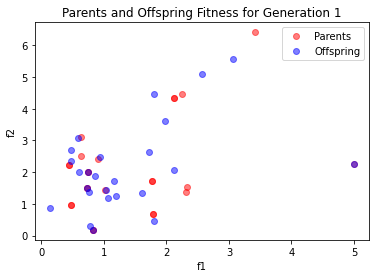

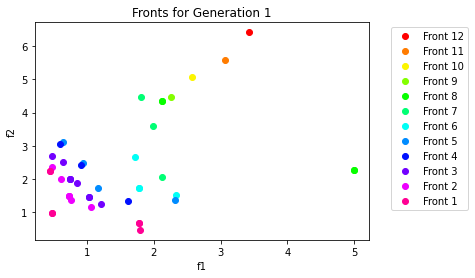

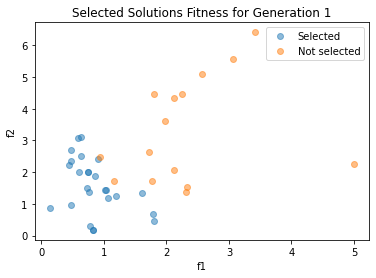

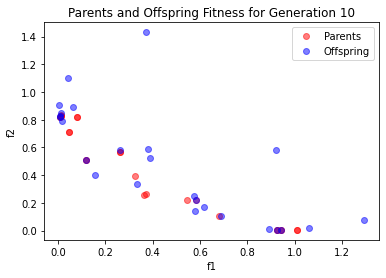

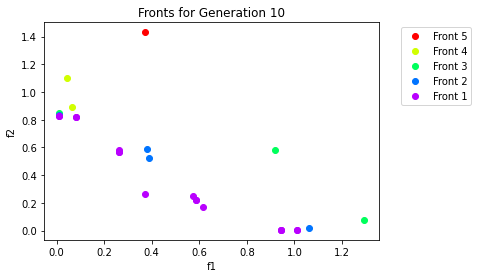

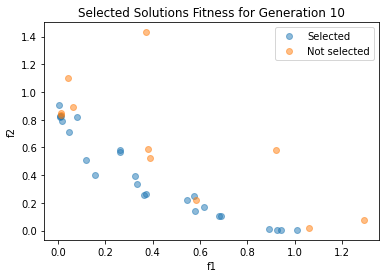

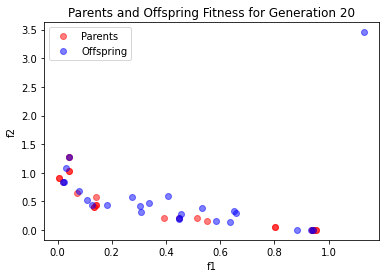

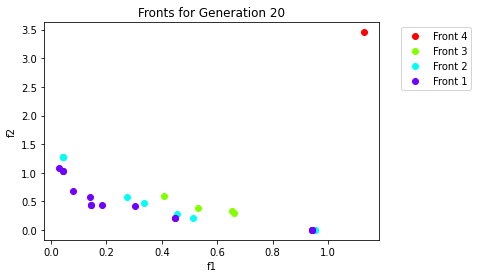

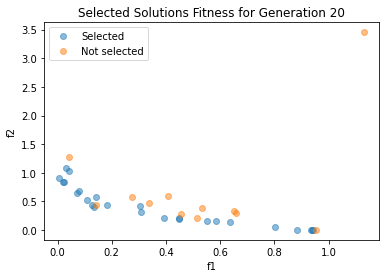

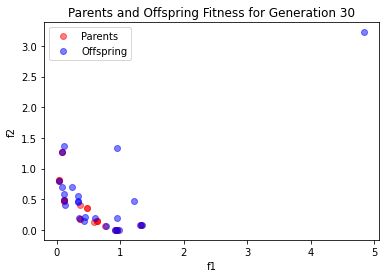

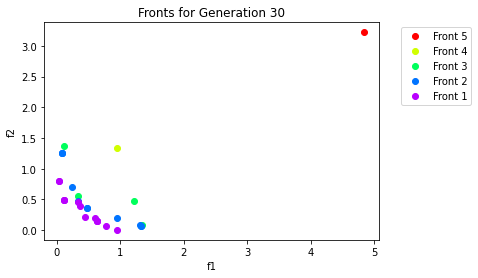

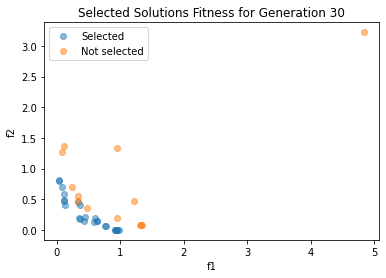

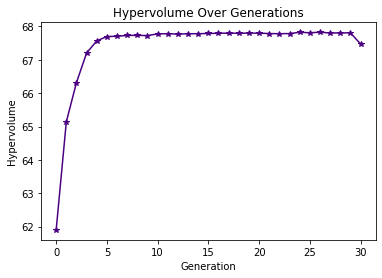

Population: 
[['1100000000', '1100000011', '1100111010'], ['1110000001', '1000011000', '1111000000'], ['1101001010', '1111011010', '1100111110'], ['1101001010', '1110000011', '1101010010'], ['1111011000', '1000011000', '1111000000'], ['1101000000', '1011111010', '1111000010'], ['1111000001', '1100000011', '1100001111'], ['0100000000', '1110010110', '1100111010'], ['1111101010', '1110010110', '1101010010'], ['1110011000', '1000011101', '1101000010'], ['1101001010', '1111011010', '1100010011'], ['1111001010', '1110010110', '1101010010'], ['1110011000', '1000011000', '1111000000'], ['1110011000', '1000011000', '1101000010'], ['1110011001', '1000011000', '1111000000'], ['0100000000', '1100000011', '1100111010'], ['1110011000', '1000010100', '1111000110'], ['1101000000', '1111011010', '1100011110'], ['1111011000', '1000010100', '1111000111'], ['1110011000', '1010010001', '1100111010'], ['1111000001', '1100001011', '1101001111'], ['1110011000', '1100001010', '1100111010'], ['1110011000', '10

In [14]:
# Run the genetic algorithm
pop = main()
print("Population: \n" + str(pop))
print("\n")